Spectra
---

Download all the Jupyter notebooks from: https://github.com/HeloiseS/hoki/tree/master/tutorials

# Initial Imports

In [1]:
from hoki import load
from hoki.spec import dopcor
import hoki.spec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pysynphot as psp

%matplotlib inline

plt.style.use('tuto.mplstyle')

### In this tutorial you will:

- Load BPASS synthetic spectra through `hoki`
- Manipulated an plot these synthetic spectra
- Compare them to observational data and find best matches 
- Get more familiar with `pandas` if you are not already
- Pass a spectrum through a filter using `hoki.spec` and `pysynphot`

# Loading Spectra in `hoki`

The synthetic spectra returned by BPASS are given in ASCII files, grouped by metallicity (`zXXX`) and whether the population is made up of just single stars (`-sin-`) or also contains binary stars (`-bin`).
Each file contains the wavelenght bin in its first column and the following 51 columns are the synthetic spectra of the population at each BPASS time bins. The wavelength ranges from 1 to 100,000 Angstrom.

We can load each file into a `pandas.DataFrame` using the `hoki.load.model_output()` function.
**This may take a few seconds.**
For the purposes of this tutorial we are only going to load two sets of synthetic spectra: solar metallicity and a tenth solar  - both including binary stars. 

In [2]:
ss_z002 = load.model_output('./data/spectra/spectra-bin-imf135_300.z002.dat')
ss_z020 = load.model_output('./data/spectra/spectra-bin-imf135_300.z020.dat')

In [3]:
ss_z002.head()

,WL,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,...,10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9,11.0
0,1.0,2.745775e-40,2.702434e-40,3.047202e-40,4.195247e-38,7.912627e-38,2.884525e-38,9.237552e-39,1.976199e-38,5.478071e-38,...,3.143051e-40,4.732241e-40,2.407628e-40,1.854254e-40,1.770071e-40,3.505892e-40,1.656219e-40,1.040945e-40,2.193011e-40,3.402488e-41
1,2.0,2.745775e-40,2.702434e-40,3.047202e-40,4.195247e-38,7.912627e-38,2.884525e-38,9.237552e-39,1.976199e-38,5.478071e-38,...,3.143051e-40,4.732241e-40,2.407628e-40,1.854254e-40,1.770071e-40,3.505892e-40,1.656219e-40,1.040945e-40,2.193011e-40,3.402488e-41
2,3.0,2.745775e-40,2.702434e-40,3.047202e-40,4.195247e-38,7.912627e-38,2.884525e-38,9.237552e-39,1.976199e-38,5.478071e-38,...,3.143051e-40,4.732241e-40,2.407628e-40,1.854254e-40,1.770071e-40,3.505892e-40,1.656219e-40,1.040945e-40,2.193011e-40,3.402488e-41
3,4.0,2.745775e-40,2.702434e-40,3.047202e-40,4.195247e-38,7.912627e-38,2.884525e-38,9.237552e-39,1.976199e-38,5.478071e-38,...,3.143051e-40,4.732241e-40,2.407628e-40,1.854254e-40,1.770071e-40,3.505892e-40,1.656219e-40,1.040945e-40,2.193011e-40,3.402488e-41
4,5.0,2.745775e-40,2.702434e-40,3.047202e-40,4.195247e-38,7.912627e-38,2.884525e-38,9.237552e-39,1.976199e-38,5.478071e-38,...,3.143051e-40,4.732241e-40,2.407628e-40,1.854254e-40,1.770071e-40,3.505892e-40,1.656219e-40,1.040945e-40,2.193011e-40,3.402488e-41


Additionally, we're going to be working with optical data, so let's crop our spectra. 

Because we are using `pandas`, we don't have to individually crope each spectrum, we can easily take care of the whole DataFrames.

In [4]:
ss_z002 = ss_z002[(ss_z002.WL>4000) & (ss_z002.WL<9000)]
ss_z020 = ss_z020[(ss_z020.WL>4000) & (ss_z020.WL<9000)]

# Plotting a spectrum

Now that we have loaded our spectra we can plot them!

**At different metallicities**

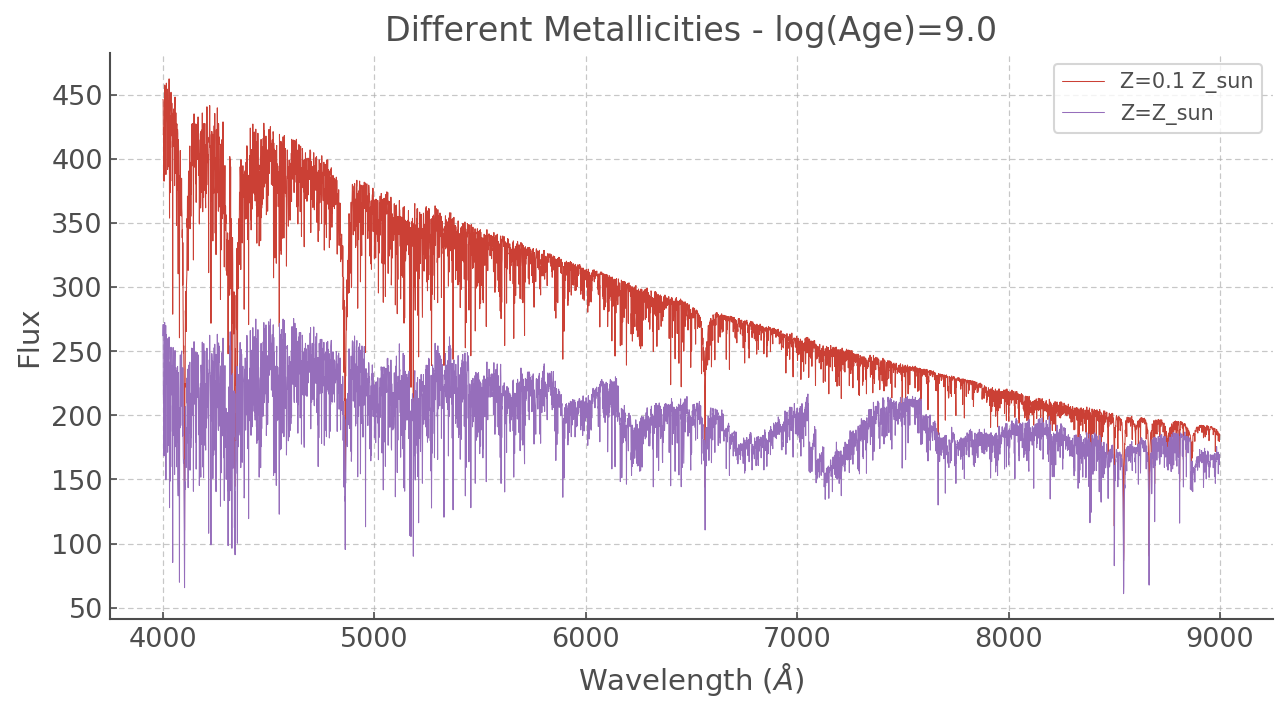

In [5]:
plt.figure(figsize=(10,5))

plt.plot(ss_z002.WL, ss_z002['9.0'], label='Z=0.1 Z_sun', lw=0.5)
plt.plot(ss_z002.WL, ss_z020['9.0'], label='Z=Z_sun', lw=0.5)

plt.title('Different Metallicities - log(Age)=9.0')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Flux')
plt.legend()

**At different ages**

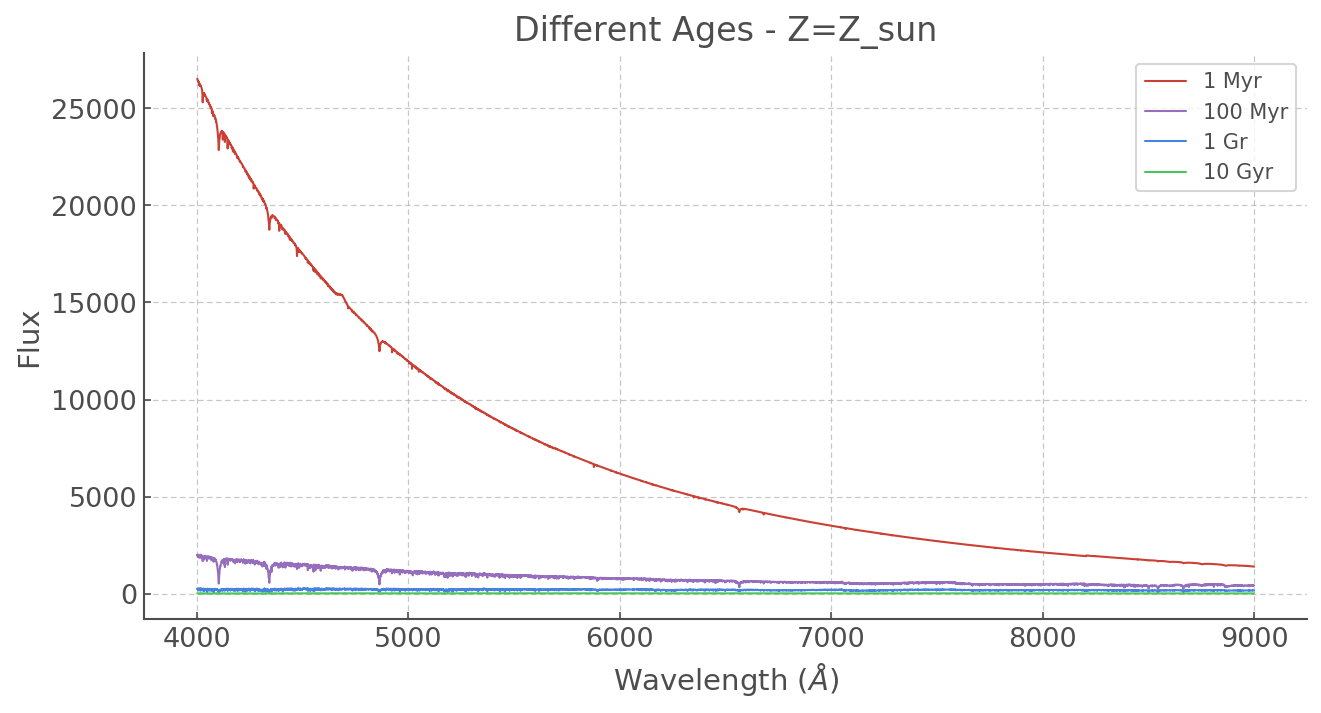

In [6]:
plt.figure(figsize=(10,5))

plt.plot(ss_z002.WL, ss_z020['6.0'], label='1 Myr', lw=1)
plt.plot(ss_z002.WL, ss_z020['8.0'], label='100 Myr', lw=1)
plt.plot(ss_z002.WL, ss_z020['9.0'], label='1 Gr', lw=1)
plt.plot(ss_z002.WL, ss_z020['10.0'], label='10 Gyr', lw=1)

plt.title('Different Ages - Z=Z_sun')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Flux')
plt.legend()

The vast difference in scales makes it tough to see the older spectra (and their forests of lines) so let's **normalise** everything. We could write a little function but why re-invent the wheel? `sklearn` has some great statistical tools including a variety of normalising methods. Let's use `MinMaxScaler()`, which simply makes sure the top values == 1 and lowest value == 0. 

In [7]:
WL = ss_z020.WL.values # Since all the wavelength ranges are the same let's give it a single name


# The 'fit_transform()' function might sound like a weird name but it makes sense when 
# you are familiar with the whole sklearn framework: it is consistent with all their other tools.
# Also note that sklearn takes in numpy arrays and returns numpy arrays. That means we have to
# input our dataframe with .values, and place the output back into a DataFrame (if that's the format we want).

ss_z020_scaled = pd.DataFrame(MinMaxScaler().fit_transform(ss_z020.values)[:,1:], # Not doing the wavelength column
                              columns = ss_z020.columns[1:]) # We also have to provide column names.

# And now we do the same for a tenth solar!
ss_z002_scaled = pd.DataFrame(MinMaxScaler().fit_transform(ss_z002.values)[:,1:], 
                              columns = ss_z002.columns[1:])

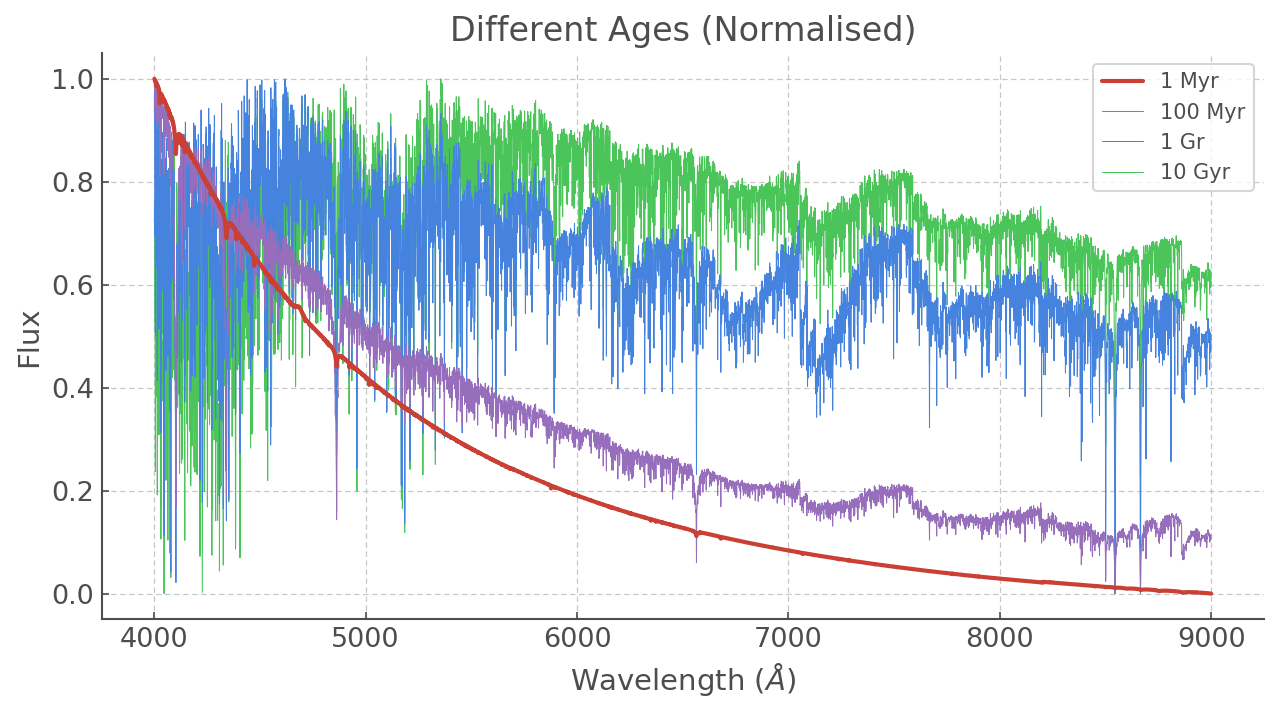

In [8]:
plt.figure(figsize=(10,5))

plt.plot(WL, ss_z020_scaled['6.0'], label='1 Myr', lw=2, zorder=5)
plt.plot(WL, ss_z020_scaled['8.0'], label='100 Myr', lw=0.5, zorder=4)
plt.plot(WL, ss_z020_scaled['9.0'], label='1 Gr', lw=0.5, zorder=3)
plt.plot(WL, ss_z020_scaled['10.0'], label='10 Gyr', lw=0.5, zorder=2)

plt.title('Different Ages (Normalised)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Flux')
plt.legend()

In [9]:
# Now you can try to make a similar plot for a tenth solar and a different range of ages!




# Comparing to some real data

Now let's play with some real data! We're going to be looking at NGC 4993 (the host galaxy of GW1708017) and then at some SDSS templates.

### NGC 4993

First, let's put it in a `pandas.DataFrame` and see what we've got. 

In [10]:
ngc4993 = pd.read_csv('./data/spectra/ngc4993.dat', sep=r"\s+", engine='python')

In [11]:
# Just to see what the Data Frame looks like
ngc4993.head()

,WL,Counts
0,4036.82,5437.012
1,4038.36,5506.620
2,4039.90,5747.366
3,4041.44,5748.782
4,4042.99,5761.701


Text(0.5, 1.0, 'NGC 4993')

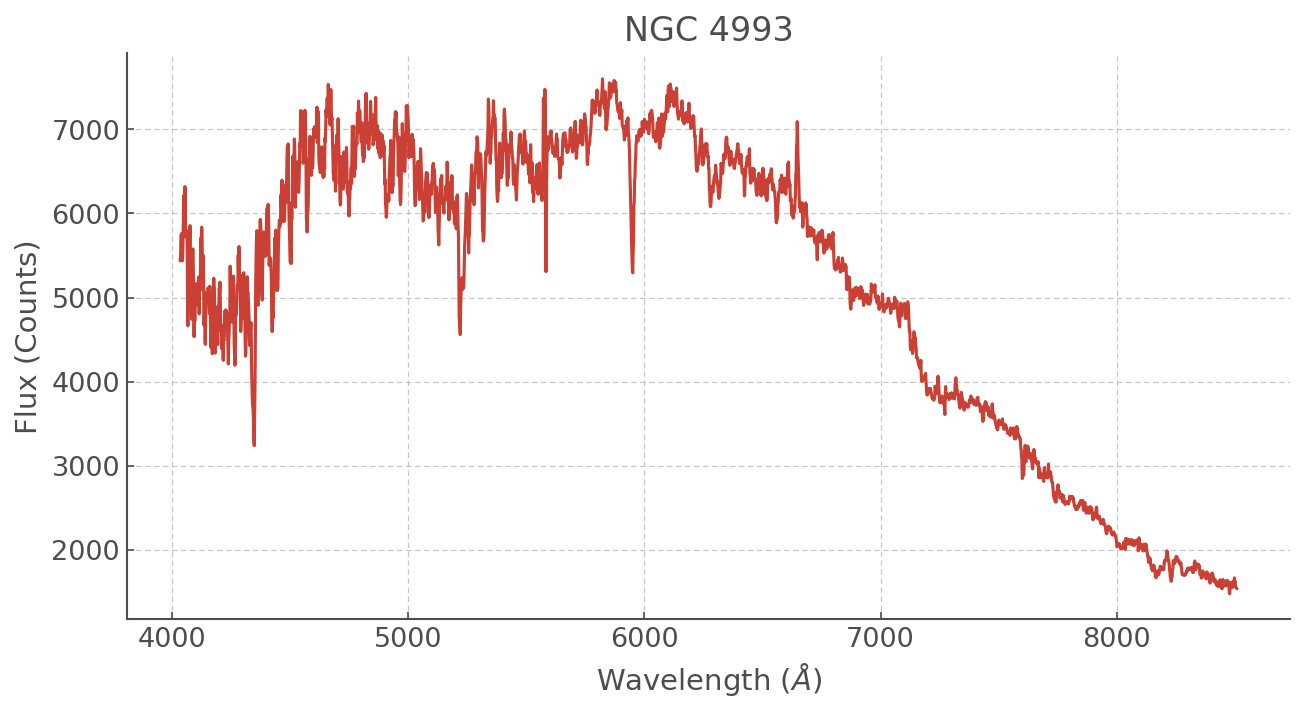

In [12]:
# and now we plot it
plt.figure(figsize=(10,5))
plt.plot(ngc4993.WL, ngc4993.Counts)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Flux (Counts)')
plt.title('NGC 4993')

This spectrum is in counts and obviously the amplitude is not going to match that of our synthetic spectra. So let's normalise this too!

In [13]:
ngc4993_scaled = pd.DataFrame(MinMaxScaler().fit_transform(ngc4993.values), columns = ['WL', 'Counts'])
ngc4993_scaled['WL'] = ngc4993['WL'] # Because with the operation above we also scaled the WL -- makes no sense. 

Another thing to remember is that a real spectrum will be redshifted. **There is a basic doppler correction within `hoki`** which you can use to take care of that. Note it will **change in place**.

In [14]:
dopcor(ngc4993_scaled, z=0.009727)

### Finding the best match

The goal here is to find the best synthetic spectrum corresponding to our observed spectrum. In this tutorial we will do this visually. Let's plot a range of ages and see what we get.

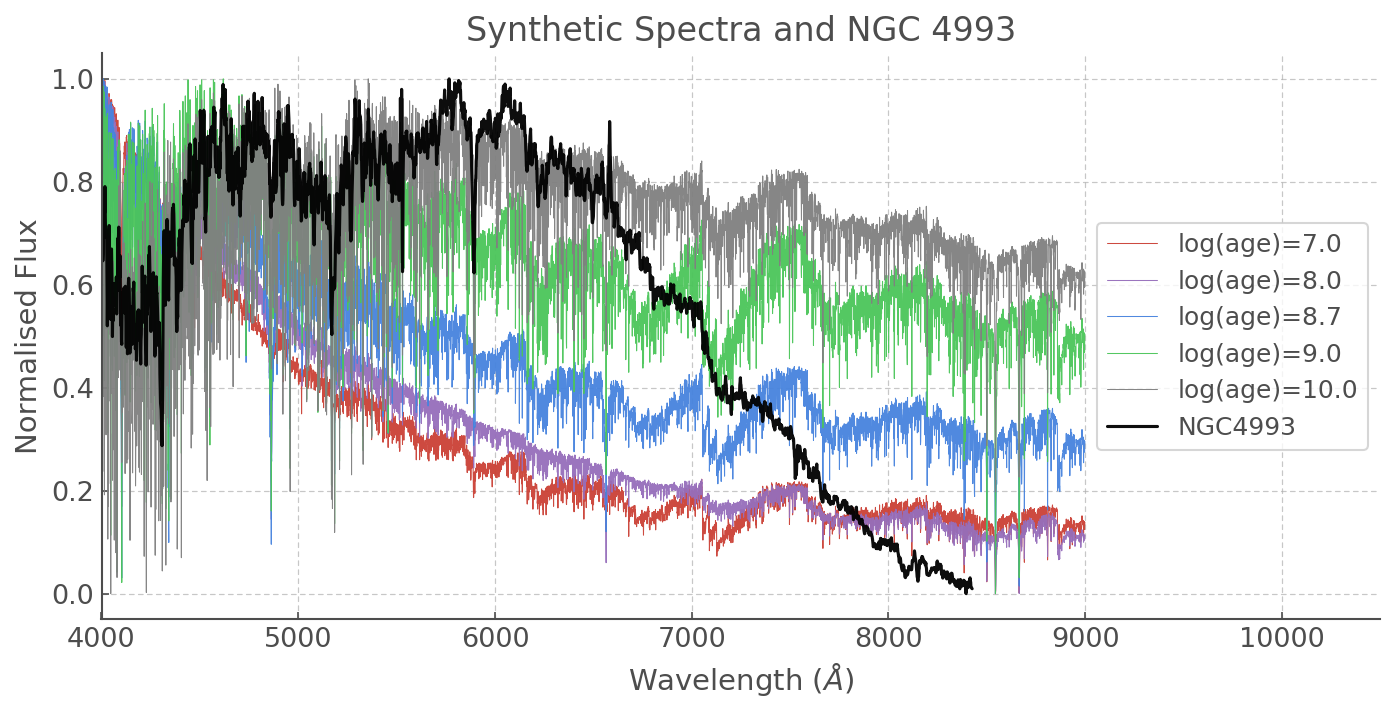

In [15]:
plt.figure(figsize=(11,5))

WL = ss_z002.WL
# The BPASS spectra
plt.plot( WL, ss_z020_scaled['7.0'], alpha=0.95, lw=0.5, label='log(age)=7.0')
plt.plot( WL, ss_z020_scaled['8.0'], alpha=0.95, lw=0.5, label='log(age)=8.0')
plt.plot( WL, ss_z020_scaled['8.7'], alpha=0.95, lw=0.5, label='log(age)=8.7')
plt.plot( WL, ss_z020_scaled['9.0'], alpha=0.95, lw=0.5, label='log(age)=9.0')
plt.plot( WL, ss_z020_scaled['10.0'], alpha=0.95, color='grey', lw=0.5, label='log(age)=10.0')

# The observational data
plt.plot(ngc4993_scaled.WL, ngc4993_scaled.Counts, alpha=0.95, c='k', label='NGC4993')

# Polishing the plot
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalised Flux')
plt.xlim([4000,10500])
plt.title('Synthetic Spectra and NGC 4993')
plt.legend(loc='right', fontsize='large')

There is an obvious drop in the flux in the red part of our NGC 4993 spectrum. That's not the galaxy - it could be something to do with the filter used or another observational reason, so let's focus on the short wavelengths. 

It looks like older ages are a better match. Here is the one I thought fitted best, but feel free to make your own plots and see if you can get a better result!

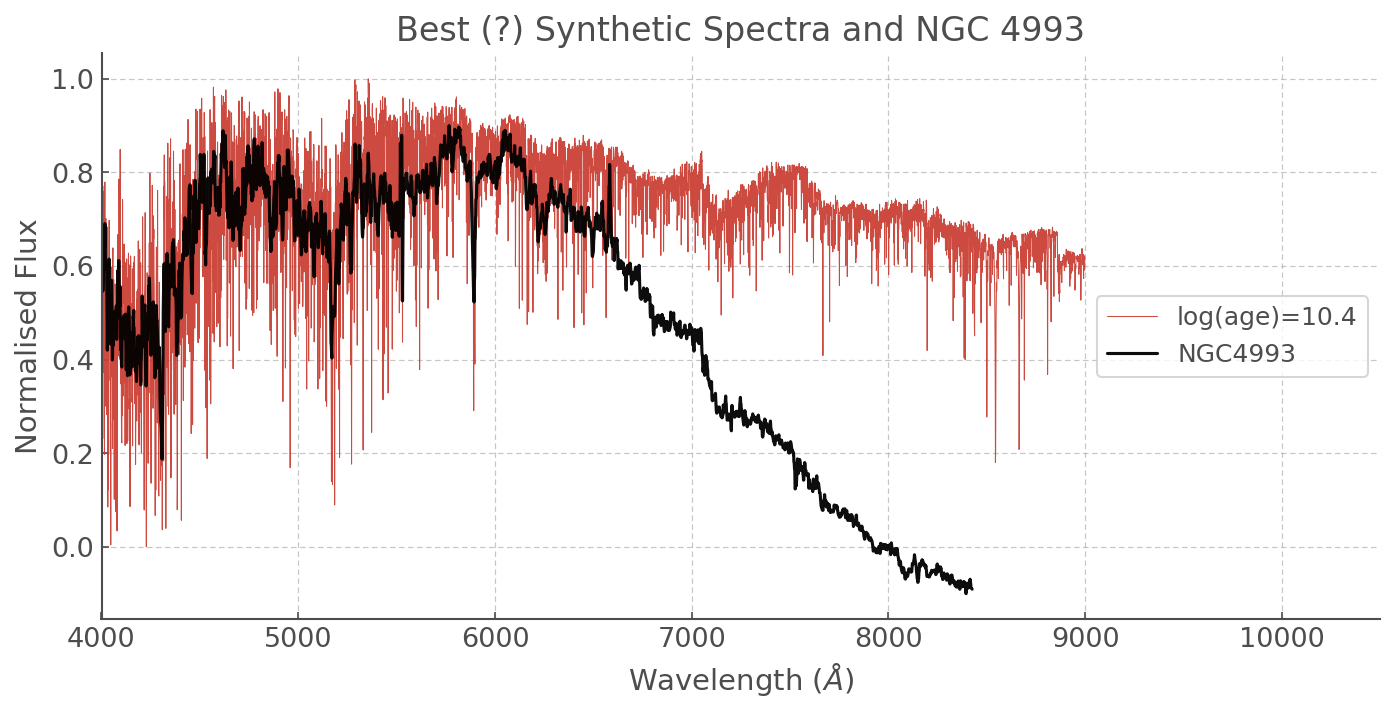

In [16]:
plt.figure(figsize=(11,5))
plt.plot( WL, ss_z020_scaled['10.4'],
         alpha=0.95, lw=0.5, label='log(age)=10.4')

plt.plot(ngc4993_scaled.WL, ngc4993_scaled.Counts-0.1, alpha=0.95, c='k', label='NGC4993')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalised Flux')
plt.xlim([4000,10500])
plt.title('Best (?) Synthetic Spectra and NGC 4993')
plt.legend(loc='right', fontsize='large')

### SDSS data 

Now let's take a look at some SDSS templates. In the folder `./data/spectra` you should have two fits files corresponding to an early-type galaxy and an indescriminate galaxy template (`spDR2-023.fit` and `spDR2-024.fit`, respectively).

Note that these spectra are given as fits files and it's beyond the scope of this tutorial to walk you through turning them into a pythonic data structure, so I've made the `extract_sdss_spectrum()` function which you can simply run to turn these spectra into a simple and convenient DataFrame.  

In [17]:
from astropy.io import fits

def extract_sdss_spectrum(dataloc):
    """
    Some Python magic to turn sdss fits files into dataframes ;) 
    
    You don't have to pay too much attention. 
    If you're curious read the comments or feel free to send me an email: hfstevance@gmail.com or DM me @sydonahi
    """
    sdss_data = fits.open(dataloc)
    
    # Normalising with sklearn
    scaled_flux = MinMaxScaler().fit_transform(sdss_data[0].data[0].reshape(-1,1))
    
    # A list comprehension incantation to make the wavelength appear **** wizard ****
    wl = [10**(sdss_data[0].header['COEFF0']+sdss_data[0].header['COEFF1']*i) 
          for i in range(sdss_data[0].data.shape[1])]
    
    # Making the dataframe
    df = pd.DataFrame(np.array([wl,scaled_flux.reshape(sdss_data[0].data[0].shape[0])]).T, 
                      columns=['WL', 'Flux'])
    return df

Let's get our SDSS spectra and take a look at them.

In [18]:
early_type_gal = extract_sdss_spectrum('./data/spectra/spDR2-023.fit')
gal = extract_sdss_spectrum('./data/spectra/spDR2-024.fit')

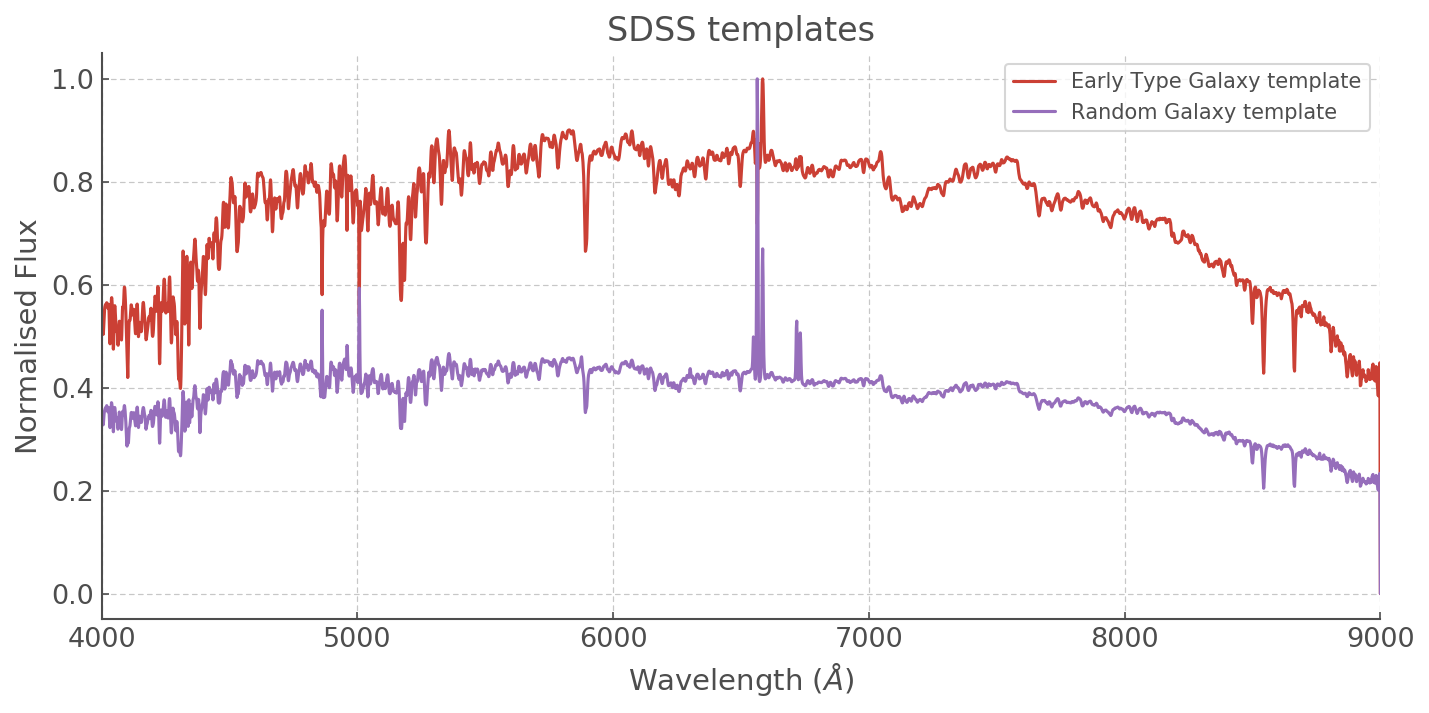

In [19]:
plt.figure(figsize=(11,5))
plt.plot(early_type_gal.WL, early_type_gal.Flux, label='Early Type Galaxy template')
plt.plot(gal.WL, gal.Flux, label='Random Galaxy template')


plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalised Flux')
plt.xlim([4000,9000])
plt.title('SDSS templates')
plt.legend()

Note a very interesting effect here in our Random Galaxy template: the large nebular line is messing with our scaler and when we want to fit it we're probably going to have to go and add a scale factor by hand so that the other features are of the same kind of amplitude as those in our synthetic spectra!

Anyway, for now we're going to focus on the Early Type Galaxy and see if we can find a template that matches. Again, let's just do it by eye. 

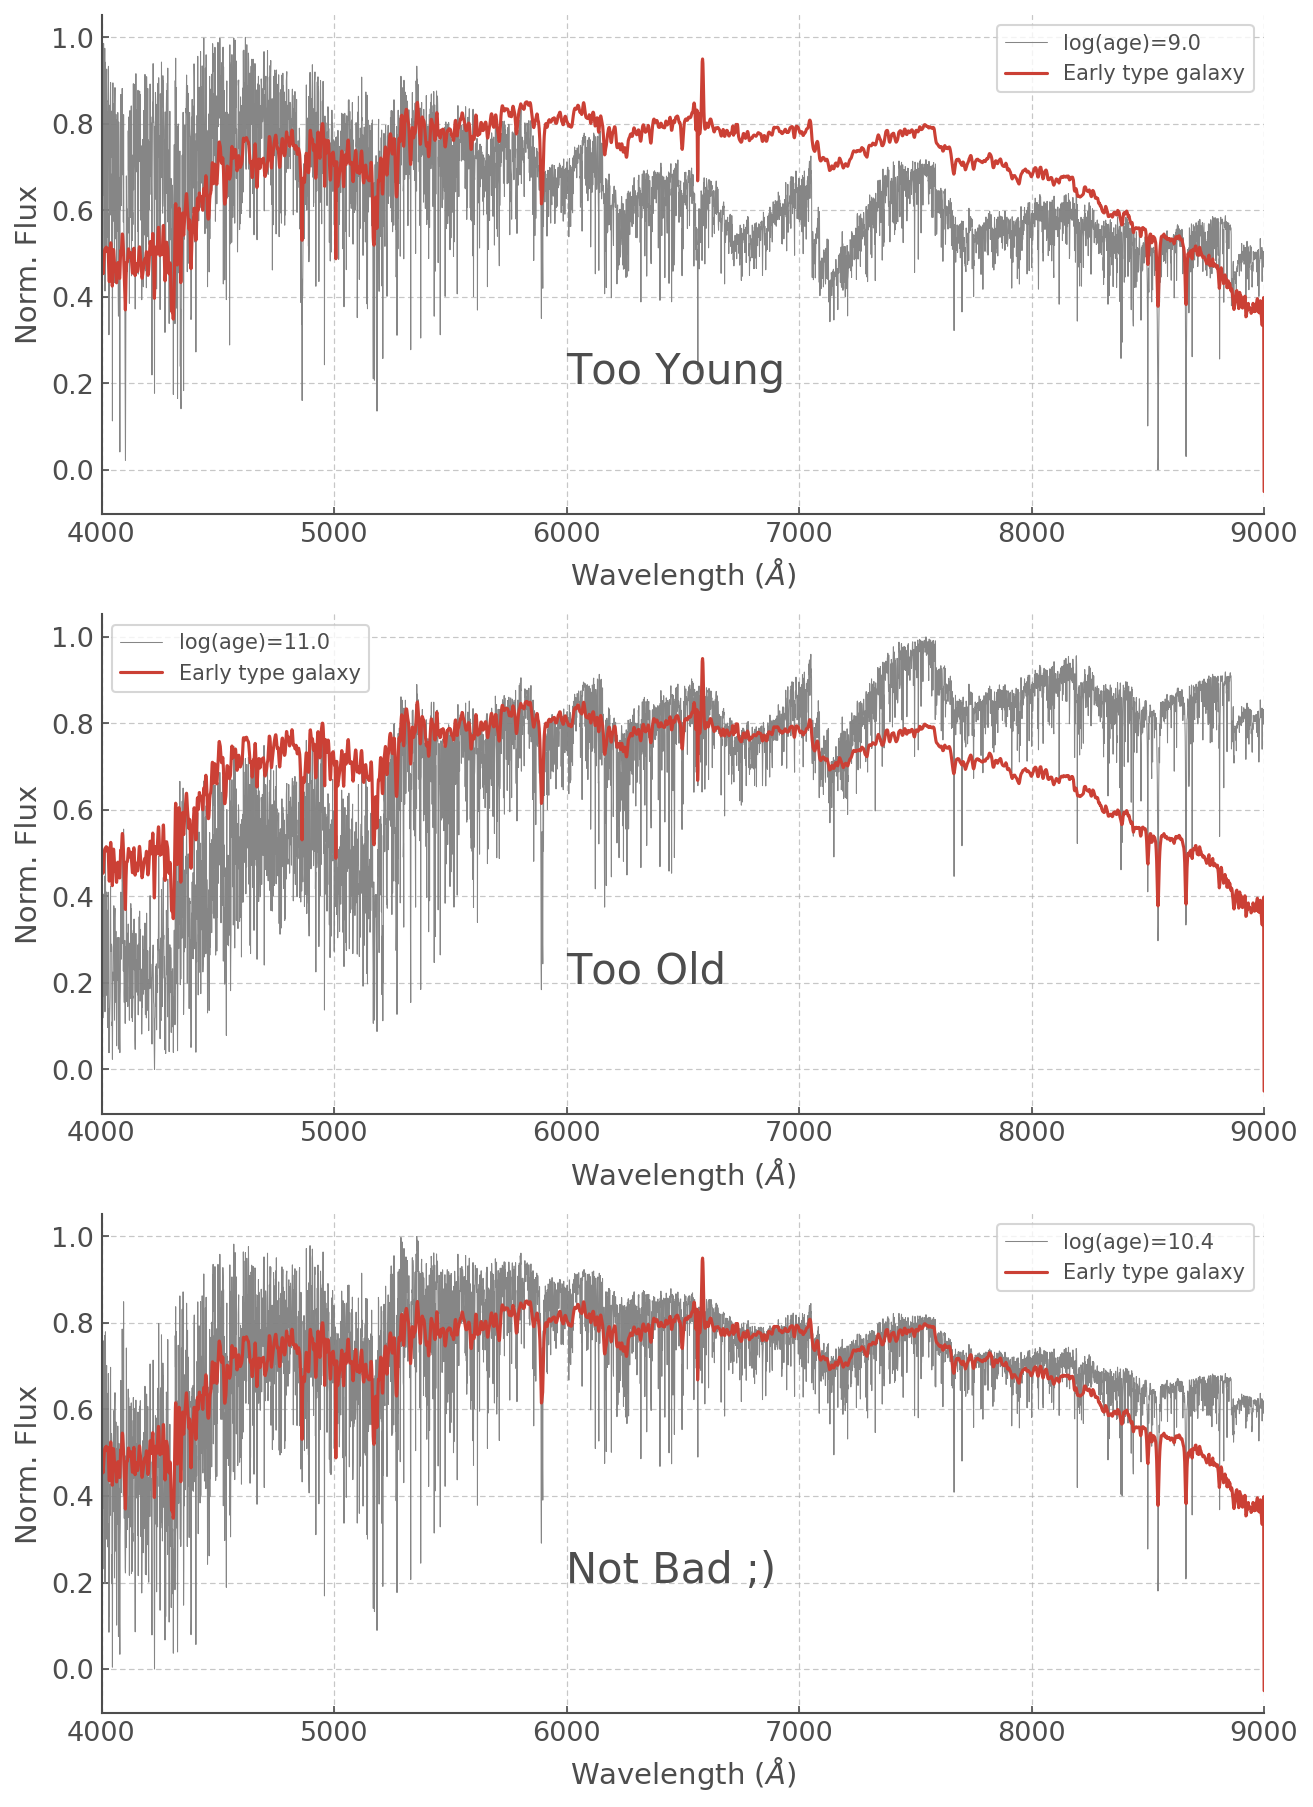

In [20]:
f, ax = plt.subplots(3, figsize=(10,15))

ax[0].plot( WL, ss_z020_scaled['9.0'],
         alpha=0.95, lw=0.5, label='log(age)=9.0', color='grey')
ax[0].text(6000, 0.2, 'Too Young', fontsize=20)
ax[1].plot( WL, ss_z020_scaled['11.0'],
         alpha=0.95, lw=0.5, label='log(age)=11.0', color='grey')
ax[1].text(6000, 0.2, 'Too Old', fontsize=20)
ax[2].plot( WL, ss_z020_scaled['10.4'],
         alpha=0.95, lw=0.5, label='log(age)=10.4', color='grey')
ax[2].text(6000, 0.2, 'Not Bad ;)', fontsize=20)


for axis in ax:
    axis.plot(early_type_gal.WL, early_type_gal.Flux-0.05, label='Early type galaxy')
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel(r'Norm. Flux')
    axis.set_xlim([4000,9000])
    axis.legend()



Feel free to play around with other ages (or even metalicities!) but a log(age) = 10.4 is not unsurprising for an Early Type Galaxy which we expect to have a relatively old stellar population (and log(age)=11.0 is much older than the age of the Universe so that was never going to work haha).

# Doing operations on Spectra

Within the `pandas` framework it is trivial to add spectra and perform mathematical operations on them. 

As an example, let's add together an old and a very young stellar population. Arbitrarily I've picked a log(age) of 6.2 and 10.5, but feel free to play around with it yourself!

In [21]:
old_and_young = ss_z020_scaled['6.2'] + ss_z020_scaled['10.5']

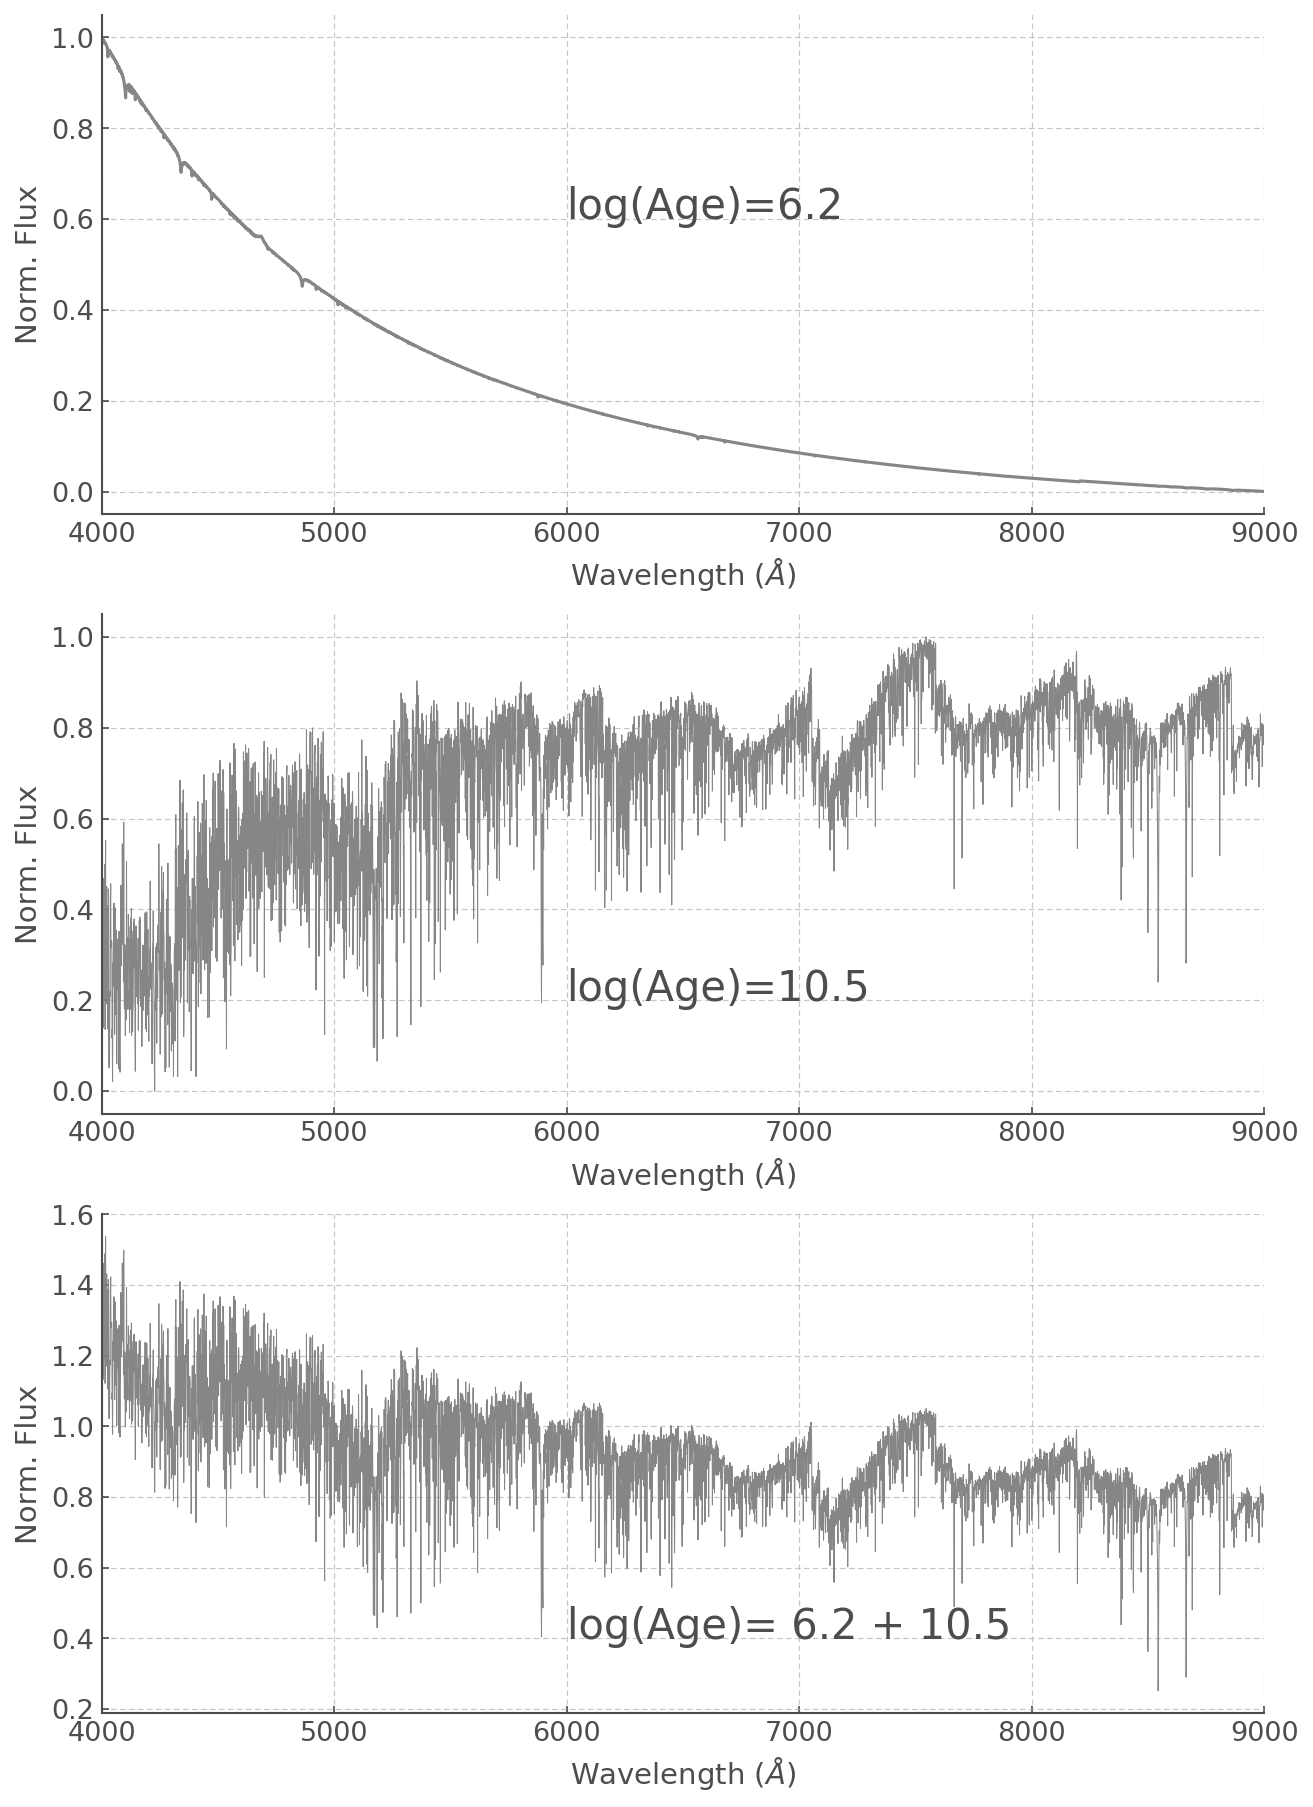

In [22]:
f, ax = plt.subplots(3, figsize=(10,15))

ax[0].plot( WL, ss_z020_scaled['6.2'],
         alpha=0.95, color='grey')
ax[0].text(6000, 0.6, 'log(Age)=6.2', fontsize=20)

ax[1].plot( WL, ss_z020_scaled['10.5'],
         alpha=0.95, lw=0.5, color='grey')
ax[1].text(6000, 0.2, 'log(Age)=10.5', fontsize=20)

ax[2].plot( WL, old_and_young,
         alpha=0.95, lw=0.5, color='grey')
ax[2].text(6000, 0.4, 'log(Age)= 6.2 + 10.5', fontsize=20)


for axis in ax:
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel(r'Norm. Flux')
    axis.set_xlim([4000,9000])


You can also add spectra in **different proportions** by simply adding **scale factors**. Multiplications, divisions and most daily mathematical operations are easily done:

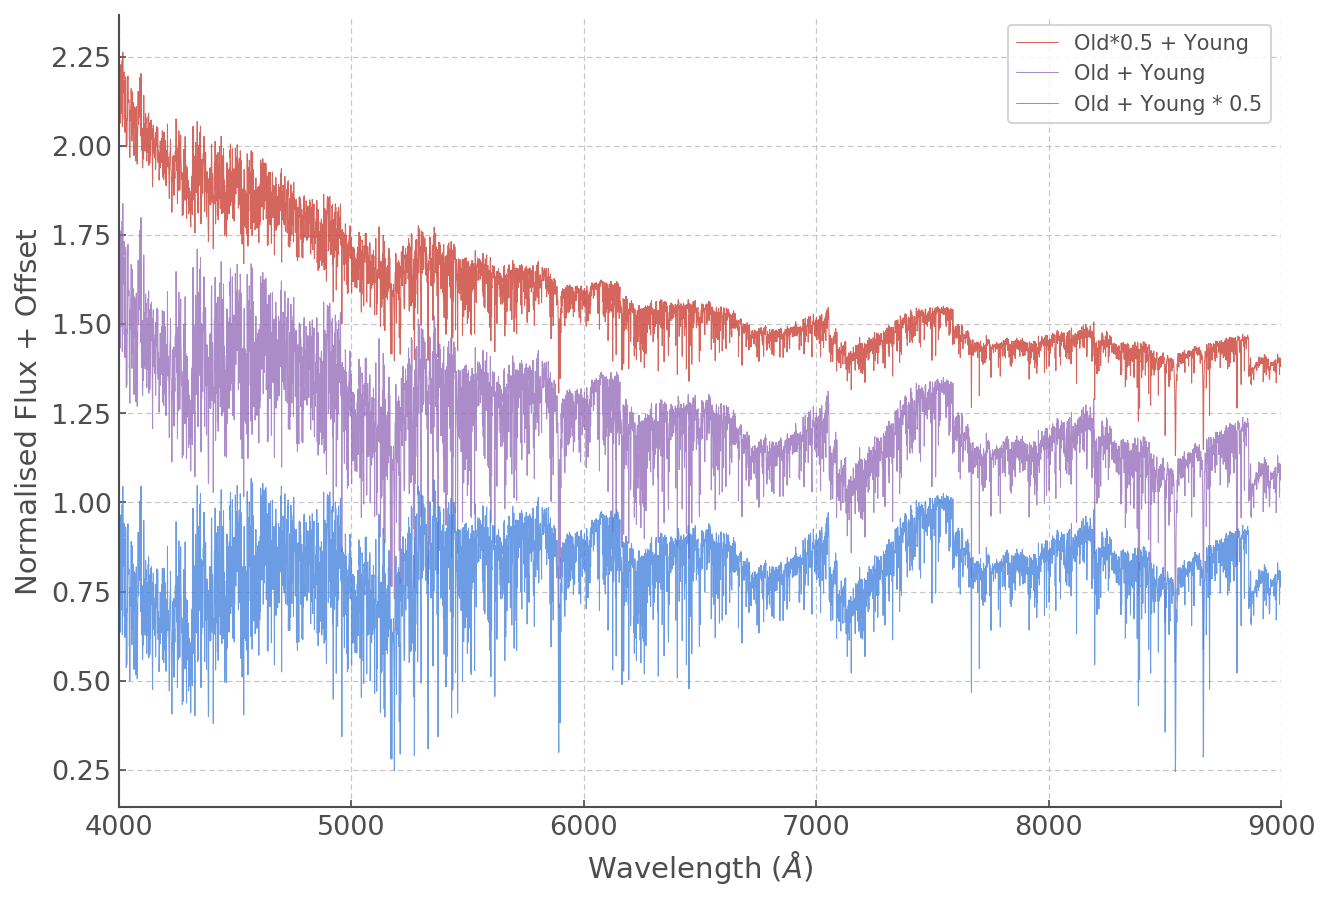

In [23]:
plt.figure(figsize=(10,7))

plt.plot(WL, (ss_z020_scaled['6.2'] + ss_z020_scaled['10.5']*0.5)+1,
         lw=0.5, alpha=0.8, label='Old*0.5 + Young')

plt.plot(WL, (ss_z020_scaled['6.2'] + ss_z020_scaled['10.5'])+0.3, 
         lw=0.5, alpha=0.8, label='Old + Young')

plt.plot(WL, (ss_z020_scaled['6.2']*0.5 + ss_z020_scaled['10.5']),
         lw=0.5, alpha=0.8, label='Old + Young * 0.5')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalised Flux + Offset')
plt.xlim([4000,9000])
plt.legend()

## Using Filters

Many telescopes use physical filter to increase the signal-to-noise ratio, but they restrict the observed wavelength region. So, we need to apply the same filtering ditigally to our BPASS spectrum for a fair comparison. For this purpose, we need a filter profile (also known as bandpass). This describes the fraction of light transmission through the filter.

An extremely useful package for this is the `pysynphot` package. Originally created for use with the Hubble Space Telescope, it has been extended to custom spectra and filters. 

`hoki.spec` contains functions to implement BPASS spectra with the `pysynphot` package. 
Here, we will apply a HST filter to a BPASS spectrum, but more information can be found in [the pysynphot documentation](https://pysynphot.readthedocs.io/en/latest/index.html). 


Using `load_bandpass()`, we can load a `pysynphot` build-in filter or load a custom filter from a file. The file must contain a VOTable with the filter profile and the name of the filter as the second parameter. These can be found on the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/).

In [24]:
# Loading build-in pysynphot filter
bp = hoki.spec.load_bandpass(f"acs,hrc,f220w")

# Loading custom filter 
custom_bp = hoki.spec.load_bandpass("./data/HST.ACS_HRC.F220W.xml")

AttributeError: module 'hoki.spec' has no attribute 'load_bandpass'

In [ ]:
plt.plot(custom_bp.wave, custom_bp.throughput)
plt.plot(bp.wave, bp.throughput, 'g--')
plt.xlabel("Angstrom")
plt.ylabel("Transmission")
plt.xlim(1500,4000)
plt.show()

`hoki.spce.get_spectrum()` takes BPASS output and turns it into a pysynphot Spectrum with 1 Angstrom width bins and erg/s/Angstrom as the flux. This allows it a bandpass to be applied to it. 

In [ ]:
# Reloading input spectra
ss_z002 = load.model_output("./data/spectra-bin-imf135_300.z002.dat")

sp = hoki.spec.get_spectrum(ss_z002.WL.values, ss_z002["6.0"].values)

In [ ]:
plt.plot(sp.wave, sp.flux)
plt.xlabel("Angstrom")
plt.ylabel("Luminosty per Wavelength [erg/s/$\AA$]")
plt.title("BPASS Spectrum [log_{10}(age)=6.0]")
plt.xlim(100,3000)
plt.show()

In [ ]:
# combine the spectra and the bandpass
obs = hoki.spec.apply_bandpass(sp, bp)

In [ ]:
plt.plot(obs.wave,obs.flux)
plt.title("Filtered BPASS Spectrum [log_{10}(age)=6.0]")
plt.xlabel("Angstrom")
plt.ylabel("Luminosty per Wavelength [erg/s/$\AA$]")
plt.xlim(100,3000)
plt.show()

## Magnitude calculations

Bandpass filter measurements are common to be given in magnitudes, either absolute or apparent.
Since we're not comparing the spectrum to a physical object with a measured distance, we will calculate the absolute magnitude of the object in the Vega system. (object at 10pc)

This calculation can be done using the `flux_to_vegamag` function. It expects a pysynphot Bandpass and Observation object, with an optional distance, such that an apparent magnitude can be calculated.

The Observation's flux has to be in erg/s/Angstrom. 


In [ ]:
mag = hoki.spec.flux_to_vegamag(bp, obs)
print(f"Absolute Magnitude: {mag}")

# It's your turn now!

Remember the random galaxy with the naughty nebular line that messed with the effectivnes of our normalisation? 

Let's go back to it!

**You now know how to select different synthetic spectra and how to scale them, now go ahead and find the best synthetic spectrum and scale factor combination!** 

*(You ca just assume a stellar population with a single age, but feel free to have fun and combine stuff if you feel like it)*

In [ ]:
### Your code here



---

**YOU'RE ALL SET!**

I hope you found this tutorial useful. If you encountered any problems, or would like to make a suggestion, feel free to open an issue on `hoki` GitHub page [here](https://github.com/HeloiseS/hoki) or on the `hoki_tutorials` GitHub [there](https://github.com/HeloiseS/hoki_tutorials).